# Case Study 1 : Data Mining in Financial Data

**Financial Data Collection:** 
* Please collect five-year stock price data of at least 5 stocks. You can choose any stocks you'd like to analyze.
* You have multiple ways of collecting financial data with Python, here is a reference: https://www.alpharithms.com/python-financial-data-491110/
* Load the data you collect and start working on your idea.


# Problem: pick a data science problem that you plan to solve using Stock Price Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data available and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

=====================================================================================================================

The problem I am trying to solve is predicting short-term stock returns for five major technology companies (NVIDIA, Apple, Samsung, Dell, Lenovo).

Stock price prediction is important because it supports investment decisions, portfolio management, and risk control. Even small improvements in prediction accuracy can translate into better investment choices and reduced risk exposure. This is also an interesting challenge since stock prices are highly volatile and influenced by many external factors, making forecasting both difficult and valuable.

The data is widely available online, which makes it well-suited for a data science project. By preparing features from historical price data and applying multiple models, such as **Linear Regression** (a simple baseline) and **Random Forest** (a more complex ensemble method), we can evaluate and compare their performance. This allows us to understand whether linear trends or more complex non-linear relationships provide better predictive power for short-term stock returns.


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Data Collection/Processing: 

In [2]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# ----------------------

# tickers 
stocks = ['NVDA', 'AAPL', '005930.KS', 'DELL', '0992.HK']  # NVIDIA, Apple, Samsung, Dell, Lenovo

# Download 5 years of stocks data, grouped by ticker
raw = yf.download(stocks, period="5y", group_by='ticker', auto_adjust=False, progress=False)

# Convert to a tidy long-form DataFrame: columns => ['Date','Ticker','Open','High','Low','Close','Adj Close','Volume']
panels = []
for t in stocks:
    df = raw[t].copy()
    df.columns.name = None
    df = df.reset_index()
    df.insert(1, 'Ticker', t)
    panels.append(df)
data = pd.concat(panels, ignore_index=True).sort_values(['Ticker', 'Date'])

# Inspect head
data.head()

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume
2598,2020-09-03,005930.KS,55600.0,56700.0,55500.0,56400.0,49647.304688,28384920.0
2599,2020-09-04,005930.KS,55200.0,55800.0,55100.0,55600.0,48943.085938,22139109.0
2600,2020-09-07,005930.KS,56100.0,57300.0,55800.0,56500.0,49735.328125,18685880.0
2601,2020-09-08,005930.KS,57400.0,58700.0,57200.0,58700.0,51671.921875,31517520.0
2602,2020-09-09,005930.KS,58200.0,59300.0,57800.0,58400.0,51407.843750,30597399.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6495 entries, 2598 to 1298
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6495 non-null   datetime64[ns]
 1   Ticker     6495 non-null   object        
 2   Open       6219 non-null   float64       
 3   High       6219 non-null   float64       
 4   Low        6219 non-null   float64       
 5   Close      6219 non-null   float64       
 6   Adj Close  6219 non-null   float64       
 7   Volume     6219 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 456.7+ KB


In [4]:
data.isnull().sum()

Date           0
Ticker         0
Open         276
High         276
Low          276
Close        276
Adj Close    276
Volume       276
dtype: int64

We can see that there are some missing values. To investigate these null values more, we group data by ticker (stock) to see which stocks have missing values.

In [5]:
data.groupby("Ticker").apply(lambda g: g.isnull().sum())

C:\Users\afafb\AppData\Local\Temp\ipykernel_6776\1404603480.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data.groupby("Ticker").apply(lambda g: g.isnull().sum())


,Date,Ticker,Open,High,Low,Close,Adj Close,Volume
Ticker,,,,,,,,
005930.KS,0,0,74,74,74,74,74,74
0992.HK,0,0,70,70,70,70,70,70
AAPL,0,0,44,44,44,44,44,44
DELL,0,0,44,44,44,44,44,44
NVDA,0,0,44,44,44,44,44,44


We can notice that Samsung (South Korea) and Lenovo (Hong Kong) stocks have more missing values compared to U.S. stocks (Apple, Dell, NVIDIA). This is due to differences in trading calendars between Asian markets and the U.S., such as local public holidays and weekends, when one market may be closed while the other is open.  

Since the dataset contains more than 6,000 rows overall, we can safely drop the rows with missing values without significantly reducing the amount of usable data.

In [6]:
# Drop rows with null values
data = data.dropna().reset_index(drop=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6219 entries, 0 to 6218
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6219 non-null   datetime64[ns]
 1   Ticker     6219 non-null   object        
 2   Open       6219 non-null   float64       
 3   High       6219 non-null   float64       
 4   Low        6219 non-null   float64       
 5   Close      6219 non-null   float64       
 6   Adj Close  6219 non-null   float64       
 7   Volume     6219 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 388.8+ KB


In [8]:
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,6219,6219.000000,6219.000000,6219.000000,6219.000000,6219.000000,6.219000e+03
mean,2023-03-03 20:51:03.386396672,13583.902642,13705.401100,13458.762766,13584.251857,12846.350704,1.141952e+08
min,2020-09-03 00:00:00,0.000000,0.000000,0.000000,4.850000,3.897794,0.000000e+00
25%,2021-12-01 00:00:00,17.282001,17.712501,16.866500,17.338625,17.307756,1.272822e+07
50%,2023-03-03 00:00:00,102.000000,104.129997,99.290001,102.000000,101.111794,4.300784e+07
75%,2024-06-03 00:00:00,193.659996,194.995003,192.254997,193.674995,191.964767,1.054553e+08
max,2025-09-03 00:00:00,90300.000000,96800.000000,89500.000000,91000.000000,85681.085938,1.543911e+09
std,NaN,27600.832804,27842.471761,27346.491379,27584.794128,26054.419451,1.742513e+08


**Summary Statistics**

The dataset spans from 2020 to 2025 with over 6,200 rows. Prices vary widely across companies: U.S. stocks are mostly in the tens to hundreds range, while Asian stocks (e.g., Samsung) reach tens of thousands. Trading volumes also show large variation, with occasional spikes above 1.5 billion. This confirms the need for feature scaling and highlights differences in market behavior across regions.


# Data Exploration: Exploring the Dataset

**Plot the daily, weekly and monthly returns of a set of stocks of your choice** 
* references:
    * https://www.investopedia.com/terms/y/yearly-rate-of-return-method.asp
    * https://www.fool.com/knowledge-center/how-to-calculate-a-monthly-return-on-investment/#:~:text=Take%20the%20ending%20balance%2C%20and,corresponds%20to%20your%20monthly%20return.
    * https://www.investopedia.com/terms/i/intraday-return.asp#:~:text=How%20Is%20Daily%20Return%20Calculated,price%2C%20then%20multiply%20by%20100. 


In [9]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# ----------------------

For plotting, I used the matplotlib and seaborn libraries to plot boxplots of the daily and monthly returns, bar chart for the annualized returns, and line plot to see the evolution of the monthly returns over time.

**Daily Returns**

In [10]:
# Calculate daily returns as the percentage change between the Close and Open prices
# Formula: Daily Return (%) = ((Close / Open) - 1) * 100
daily_returns = (data['Close'] / data['Open'] - 1) * 100

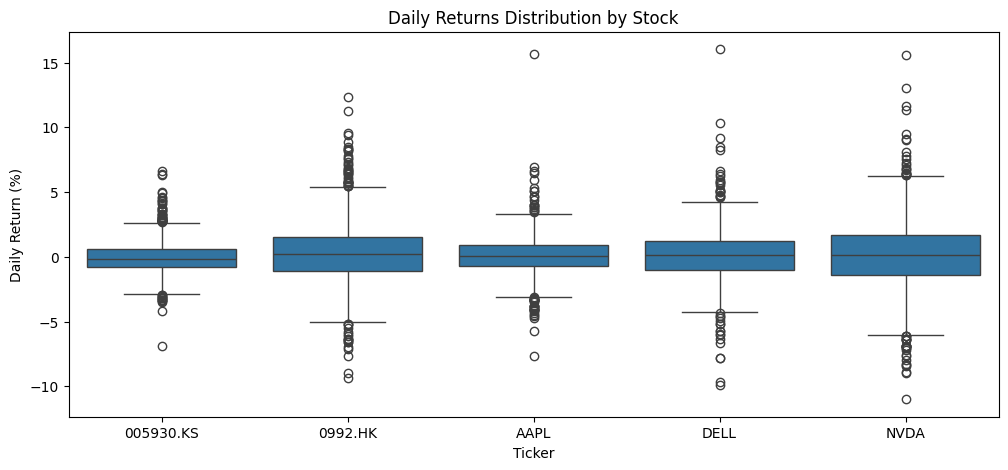

In [11]:
# --- DAILY RETURNS (boxplot by ticker) ---
data["Daily Return"] = daily_returns
plt.figure(figsize=(12,5))
sns.boxplot(x="Ticker", y="Daily Return", data=data)
plt.title("Daily Returns Distribution by Stock")
plt.ylabel("Daily Return (%)")
plt.show()

<u>**Daily Returns**</u>

The daily returns are centered around 0%.
- NVIDIA (NVDA) shows the widest spread and most extreme outliers — indicating high volatility.
- Samsung (005930.KS) shows relatively low variance compared to the others.
- Lenovo (0992.HK) has more extreme downside outliers compared to Apple and Dell.

**Weekly Returns**

In [12]:
# 1) Resample daily data to weekly frequency for each ticker
# We take the first and last Close prices of each week
weekly_prices = data.groupby("Ticker").resample("W", on="Date")['Close'].agg(['first','last']).reset_index()

# 2) Calculate weekly returns using the formula: (Ending Price / Starting Price - 1)
weekly_prices["Weekly return"] = (weekly_prices['last'] / weekly_prices['first'] - 1)

# 3) Convert to percentage
weekly_returns = weekly_prices["Weekly return"] * 100

<Figure size 1000x600 with 0 Axes>

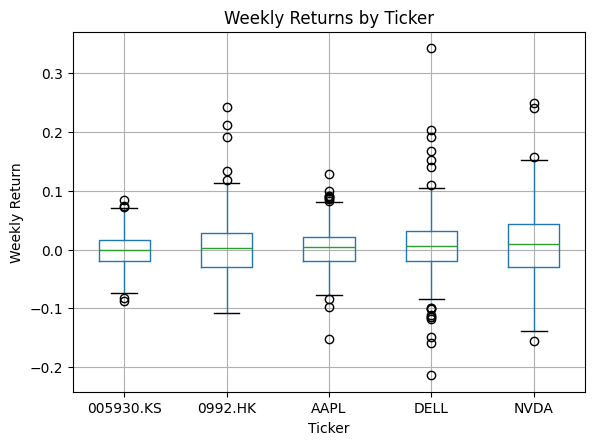

In [13]:
plt.figure(figsize=(10, 6))
weekly_prices.boxplot(column="Weekly return", by="Ticker")
plt.title("Weekly Returns by Ticker")
plt.suptitle("") 
plt.ylabel("Weekly Return")
plt.show()

<u>**Weekly Returns**</u>                              
- Median weekly returns for all stocks are close to zero, meaning that on average, prices neither rise nor fall drastically week-to-week.
- Spread (IQR) varies: Lenovo and NVIDIA exhibit wider boxes, suggesting higher volatility compared to Samsung and Apple.
- Outliers are visible for all stocks, indicating weeks with unusually high gains or losses. Dell and NVIDIA in particular show extreme positive and negative outliers, reflecting their higher risk profile.

**Monthly Returns**

In [14]:
# 1) Resample daily data to monthly frequency for each ticker
# We take the first and last Close prices of each month
monthly_prices = data.groupby("Ticker").resample("ME", on="Date")['Close'].agg(['first','last']).reset_index()

# 2) Calculate monthly returns using the formula: Monthly Return = (Ending Price / Starting Price - 1) 
monthly_prices["Monthly return"] = (monthly_prices['last'] / monthly_prices['first'] - 1)
monthly_returns = monthly_prices["Monthly return"] * 100 # Convert to %

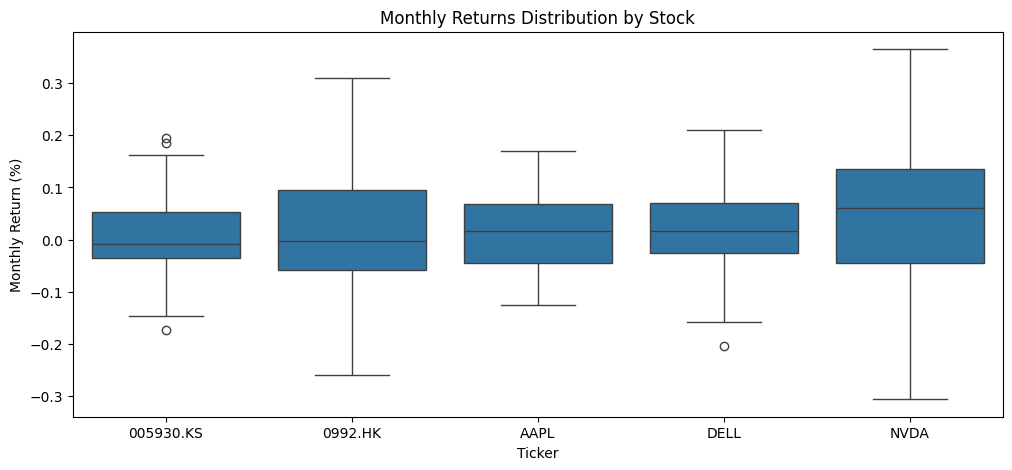

In [15]:
# --- MONTHLY RETURNS (boxplot) ---
plt.figure(figsize=(12,5))
sns.boxplot(x="Ticker", y="Monthly return", data=monthly_prices)
plt.title("Monthly Returns Distribution by Stock")
plt.ylabel("Monthly Return (%)")
plt.show()

<u>**Monthly Returns**</u>

Monthly returns are less volatile than daily returns but still vary widely.
- NVIDIA again has the highest spread, confirming its strong growth potential but higher risk.
- Apple and Dell show moderate variability with balanced return distributions.
- Samsung remains the most stable, but also with lower median returns.

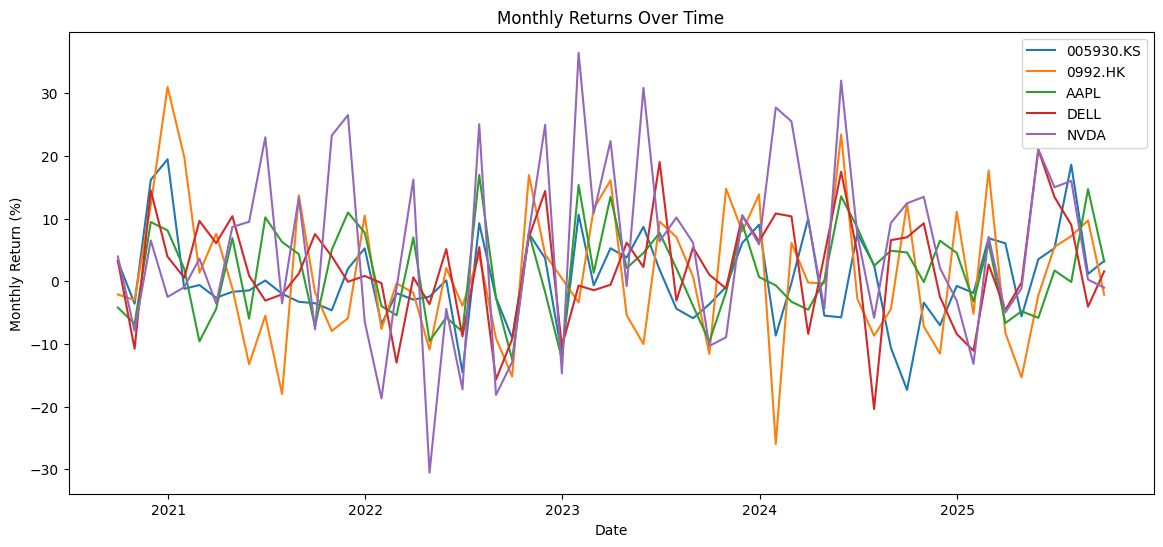

In [16]:
# --- MONTHLY RETURNS OVER TIME (line plot) ---
plt.figure(figsize=(14,6))
for ticker in monthly_prices["Ticker"].unique():
    subset = monthly_prices[monthly_prices["Ticker"] == ticker]
    plt.plot(subset["Date"], subset["Monthly return"]*100, label=ticker)

plt.title("Monthly Returns Over Time")
plt.ylabel("Monthly Return (%)")
plt.xlabel("Date")
plt.legend()
plt.show()

- NVIDIA’s line shows large swings (both positive and negative), confirming high volatility.
- Apple and Dell’s returns fluctuate less but follow broader market cycles.
- Samsung’s returns are muted and stable, rarely hitting extreme highs or lows.
- Lenovo shows sharp downward movements occasionally, making it less predictable.

**Other data explorations you would like to present:**

**Annual Returns**

In [17]:
# 1) Group monthly returns by ticker
# 2) Compound the monthly returns to calculate the annualized return
# Formula: Annualized Return = (Product of (1 + monthly_return))^(12 / number_of_months) - 1
# This gives the equivalent yearly return accounting for monthly compounding
annual_returns = (
    monthly_prices.groupby("Ticker")["Monthly return"]
    .apply(lambda x: (1 + x).prod() ** (12/len(x)) - 1)
)

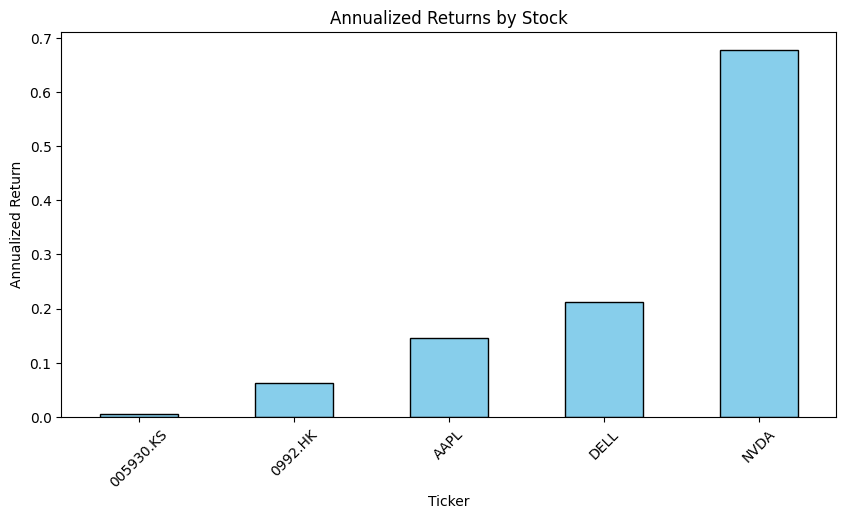

In [18]:
# --- ANNUALIZED RETURNS (bar chart) ---
plt.figure(figsize=(10,5))
annual_returns.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Annualized Returns by Stock")
plt.ylabel("Annualized Return")
plt.xlabel("Ticker")
plt.xticks(rotation=45)
plt.show()

<u>**Annual Returns**</u>

- NVIDIA (NVDA) dominates with an annualized return above 60%, far higher than the others.
- Dell and Apple follow with ~20% and ~12% annualized returns, respectively.
- Lenovo (0992.HK) is modest at ~6–7%.
- Samsung shows near 0% annualized returns, suggesting stagnation over the last 5 years.

# The Solution: implement a data science solution to the problem you are trying to solve.

**Briefly describe the idea of your solutions to the problem in the following cell (you should use at least 2 methods/models to solve the problem, and compare the performance. Feel free to use any machine learning models or statistical models.):**

#### Solution Idea

The solution uses stock price data to predict the next day’s return based on features such as Open, High, Low, Adjusted Close, and Volume.              

After preparing and scaling the data, multiple regression models are trained, including **Linear Regression** (a simple baseline), and **Random Forest Regressor** (an ensemble of decision trees for more robust predictions).                   

The models are then evaluated using **Mean Squared Error (MSE)** and **Root Mean Squared Error (RMSE)**, allowing us to directly compare their performance and determine which approach best captures the patterns in the stock data.  

- MSE: the average of the squared differences between predicted and actual values.
- RMSE: the square root of MSE, which converts the error back into the same units as the target variable (stock returns). This makes it easier to interpret and directly compare with the original data.


**Write codes to implement the solution in python:**

#### Code Workflow Explanation

The workflow begins with `prepare_data(df)`, which selects features (`Open`, `High`, `Low`, `Adj Close`, `Volume`) and creates the target as the next day’s percentage change in `Adj Close`, cleaning NaN values in the process.                                             
Then, `train_models(X_train, y_train_reg)` fits two regression models (Linear Regression and Random Forest) on the training data.                   
Finally, `evaluate_models(models, X_test, y_test_reg)` tests these models on unseen data using Mean Squared Error (MSE) and Root Mean Squared Error (RMSE), allowing comparison of model performance.  

In [19]:
def prepare_data(df):
    """Prepare dataset for regression modeling"""
    
    # Select input features (independent variables) to be used for prediction
    features = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
    
    # X = the feature columns
    X = df[features]
    
    # y_reg = the target variable
    # Here we use the *percentage change* in 'Adj Close' shifted by -1
    # This means we are trying to predict the NEXT day's return based on today's data
    y_reg = df['Adj Close'].pct_change().shift(-1)  
    
    # Combine features (X) and target (y_reg) into one DataFrame
    # Drop any rows with NaN values (caused by pct_change and shifting)
    data = pd.concat([X, y_reg.rename("Next_Close")], axis=1).dropna()
    
    # Reassign cleaned features and target
    X = data[features]
    y_reg = data['Next_Close']
   
    # Return features (X) and target (y_reg) for model training
    return X, y_reg


In [20]:
def train_models(X_train, y_train_reg):
    """Train multiple regression models on the training dataset"""
    
    # Initialize regression models:
    # Linear Regression (simple baseline model)
    lr_reg = LinearRegression()
    
    # Random Forest Regressor (ensemble of decision trees, with limited depth for control)
    rf_reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=5)
    
    # Train (fit) each model on the training dataset
    lr_reg.fit(X_train, y_train_reg)
    rf_reg.fit(X_train, y_train_reg)
    
    # Return all trained models inside a dictionary for easy access
    return {
        'regression': {
            'linear_regression': lr_reg,
            'random_forest': rf_reg
        }
    }

In [21]:
def evaluate_models(models, X_test, y_test_reg):
    """Evaluate trained models using Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)"""
    
    results = {}
    reg_results = {}
    
    # Loop through each trained regression model
    for name, model in models['regression'].items():
        # Make predictions on the test dataset
        predictions = model.predict(X_test)
        
        # Calculate Mean Squared Error
        mse = mean_squared_error(y_test_reg, predictions)
        
        # Calculate Root Mean Squared Error (square root of MSE)
        rmse = np.sqrt(mse)
        
        # Save the results in a dictionary
        reg_results[name] = {'MSE': mse, 'RMSE': rmse}
    
    # Return evaluation results for all regression models
    return {'regression': reg_results}

In [22]:
# Create a dictionary of DataFrames, one per stock ticker
dfs = {ticker: df for ticker, df in data.groupby("Ticker")}

# Dictionary to store evaluation results for all tickers
results = {}

# Loop through each stock ticker and its corresponding DataFrame
for ticker, df in dfs.items():
        print(f"\n{'='*50}")
        print(f"Analyzing stock: {ticker}")
        print(f"{'='*50}")
        
        # 1) Prepare features (X) and target (y_reg)
        X, y_reg = prepare_data(df)
        
        # 2) Split data into training and testing sets (80% train, 20% test)
        # shuffle=False ensures chronological order is preserved (for time series)
        X_train, X_test, y_train_reg, y_test_reg = train_test_split(
            X, y_reg, test_size=0.2, random_state=42, shuffle=False
        )
        
        # 3) Scale the features
        # StandardScaler standardizes data to mean=0 and variance=1
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 4) Train regression models on the scaled training data
        models = train_models(X_train_scaled, y_train_reg)
        
        # 5) Evaluate models on the scaled test data
        evaluation = evaluate_models(models, X_test_scaled, y_test_reg)
        
        # Save evaluation results for this ticker
        results[ticker] = evaluation
        
        # Step 6: Print results in a readable format
        print("\nRegression Results:")
        for model_name, metrics in evaluation['regression'].items():
            print(f"{model_name:20s}: MSE={metrics['MSE']:.6f}, RMSE={metrics['RMSE']:.6f}")


Analyzing stock: 005930.KS

Regression Results:
linear_regression   : MSE=0.000417, RMSE=0.020419
random_forest       : MSE=0.000423, RMSE=0.020562

Analyzing stock: 0992.HK

Regression Results:
linear_regression   : MSE=0.001044, RMSE=0.032311
random_forest       : MSE=0.001033, RMSE=0.032139

Analyzing stock: AAPL

Regression Results:
linear_regression   : MSE=0.000422, RMSE=0.020553
random_forest       : MSE=0.000414, RMSE=0.020350

Analyzing stock: DELL

Regression Results:
linear_regression   : MSE=0.001070, RMSE=0.032710
random_forest       : MSE=0.001121, RMSE=0.033475

Analyzing stock: NVDA

Regression Results:
linear_regression   : MSE=0.001028, RMSE=0.032065
random_forest       : MSE=0.001434, RMSE=0.037868


# Results: summarize and visualize the results discovered from the analysis

**Summarize the results of different models. Compare the perfomance and explain it. Please use figures or tables to present the results.**


In [23]:
# Print header for summary comparison
print(f"\n{'='*60}")
print("SUMMARY COMPARISON ACROSS ALL STOCKS")
print(f"{'='*60}")
   
# List to store summary information for each stock
summary_data = []

# Loop through evaluation results for each stock
for stock, eval_results in results.items():
    # Find the regression model with the lowest RMSE (best performance)
    best_reg = min(eval_results['regression'].items(), key=lambda x: x[1]['RMSE'])
        
    # Save stock name, best model, and its RMSE into the summary list
    summary_data.append({
       'Stock': stock,
       'Best_Reg_Model': best_reg[0],      # Model name (e.g., linear_regression)
       'Best_Reg_RMSE': best_reg[1]['RMSE'] # Corresponding RMSE value
    })
    
    # Convert the collected summary data into a DataFrame for tabular view
    summary_df = pd.DataFrame(summary_data)

# Print summary table in a neat format
print("\nPerformance Summary:")
print(summary_df.to_string(index=False))


SUMMARY COMPARISON ACROSS ALL STOCKS

Performance Summary:
    Stock    Best_Reg_Model  Best_Reg_RMSE
005930.KS linear_regression       0.020419
  0992.HK     random_forest       0.032139
     AAPL     random_forest       0.020350
     DELL linear_regression       0.032710
     NVDA linear_regression       0.032065


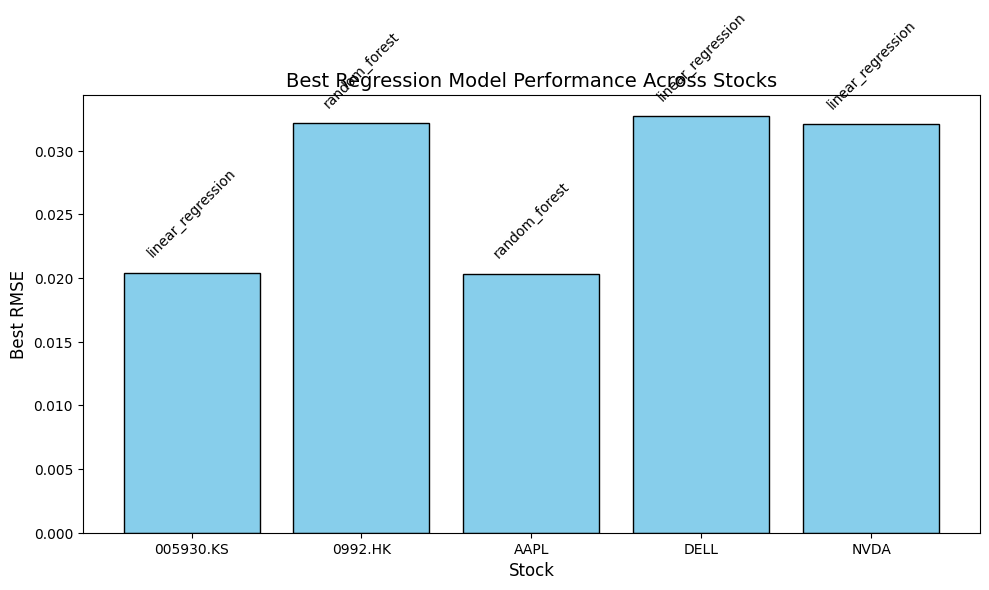

In [24]:
# Plot best RMSE per stock
plt.figure(figsize=(10, 6))
plt.bar(summary_df['Stock'], summary_df['Best_Reg_RMSE'], color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Best Regression Model Performance Across Stocks", fontsize=14)
plt.xlabel("Stock", fontsize=12)
plt.ylabel("Best RMSE", fontsize=12)

# Annotate bars with model names
for i, (rmse, model) in enumerate(zip(summary_df['Best_Reg_RMSE'], summary_df['Best_Reg_Model'])):
    plt.text(i, rmse + 0.001, model, ha='center', va='bottom', fontsize=10, rotation=45)

plt.tight_layout()
plt.show()

**Stock Return Analysis and Model Performance**

Exploring returns showed that **Samsung** was the most stable, while **NVIDIA** was the most volatile with extreme outliers. **Apple** and **Dell** displayed moderate variability, and **Lenovo** had wider spreads with downside risks.

The RMSE results align with these patterns:

- **Stable stocks (Samsung, Dell)** → Linear Regression performed best.  
- **Moderately volatile stocks (Apple, Lenovo)** → Random Forest captured complexity better.  
- **Highly volatile NVIDIA** → Linear Regression surprisingly worked best, suggesting linear patterns still dominate its short-term movements.

Linear Regression performed best for most stocks (**Samsung, Dell, NVIDIA**), suggesting that their next-day returns follow patterns that are captured reasonably well by a simple linear relationship with the chosen features.  

Random Forest performed better for **Apple** and **Lenovo**, indicating that for these stocks, non-linear relationships or feature interactions are more important and better captured by an ensemble of decision trees.

RMSE values are relatively small (around 0.02–0.03), showing that the models provide consistent but not perfect predictions — which is expected, since stock prices are inherently noisy and difficult to forecast.


# Done

All set! 

**What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and submit it in BrightSpace. This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. 


**How to submit:**
* Please submit through BrightSpace, in the Assignment "Case Study 1".
        
        
